In [44]:
import pandas as pd
import numpy as np

# Load your new, complete master dataset
file_path = '../data/master_dataset_2011-2025.csv'
master_df = pd.read_csv(file_path)

# --- Historical Ballon d'Or Top 10 Finalists by Season ---
ballon_dor_history = {
    '2024-2025': ['Ousmane Dembele', 'Lamine Yamal', 'Vitinha', 'Raphinha', 'Mohammed Salah', 'Kylian Mbappe', 'Achraf Hakimi', 'Desire Doue', 'Kvicha Kvaratskhelia', 'Nuno Mendes'],
    '2023-2024': ['Rodri', 'Vinícius Júnior', 'Jude Bellingham', 'Dani Carvajal', 'Lautaro Martinez', 'Toni Kroos', 'Kylian Mbappé', 'Harry Kane', 'Phil Foden', 'Lamine Yamal'],
    '2022-2023': ['Lionel Messi', 'Erling Haaland', 'Kylian Mbappé', 'Kevin De Bruyne', 'Rodri', 'Vinícius Júnior', 'Julián Álvarez', 'Victor Osimhen', 'Bernardo Silva', 'Luka Modrić'],
    '2021-2022': ['Karim Benzema', 'Sadio Mané', 'Kevin De Bruyne', 'Robert Lewandowski', 'Mohamed Salah', 'Kylian Mbappé', 'Thibaut Courtois', 'Vinícius Júnior', 'Luka Modrić', 'Erling Haaland'],
    '2020-2021': ['Lionel Messi', 'Robert Lewandowski', 'Jorginho', 'Karim Benzema', 'N\'Golo Kanté', 'Cristiano Ronaldo', 'Mohamed Salah', 'Kevin De Bruyne', 'Kylian Mbappé', 'Gianluigi Donnarumma'],
    '2018-2019': ['Lionel Messi', 'Virgil van Dijk', 'Cristiano Ronaldo', 'Sadio Mané', 'Mohamed Salah', 'Kylian Mbappé', 'Alisson', 'Robert Lewandowski', 'Bernardo Silva', 'Riyad Mahrez'],
    '2017-2018': ['Luka Modrić', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Kylian Mbappé', 'Lionel Messi', 'Mohamed Salah', 'Raphaël Varane', 'Eden Hazard', 'Kevin De Bruyne', 'Harry Kane'],
    '2016-2017': ['Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Gianluigi Buffon', 'Luka Modrić', 'Sergio Ramos', 'Kylian Mbappé', 'N\'Golo Kanté', 'Robert Lewandowski', 'Harry Kane'],
    '2015-2016': ['Cristiano Ronaldo', 'Lionel Messi', 'Antoine Griezmann', 'Luis Suárez', 'Neymar', 'Gareth Bale', 'Riyad Mahrez', 'Jamie Vardy', 'Gianluigi Buffon', 'Pepe'],
    '2014-2015': ['Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Robert Lewandowski', 'Luis Suárez', 'Thomas Müller', 'Manuel Neuer', 'Eden Hazard', 'Andrés Iniesta', 'Alexis Sánchez'],
    '2013-2014': ['Cristiano Ronaldo', 'Lionel Messi', 'Manuel Neuer', 'Arjen Robben', 'Thomas Müller', 'Philipp Lahm', 'Neymar', 'James Rodríguez', 'Toni Kroos', 'Ángel Di María'],
    '2012-2013': ['Cristiano Ronaldo', 'Lionel Messi', 'Franck Ribéry', 'Zlatan Ibrahimović', 'Neymar', 'Andrés Iniesta', 'Robin van Persie', 'Arjen Robben', 'Gareth Bale', 'Andrea Pirlo'],
    '2011-2012': ['Lionel Messi', 'Cristiano Ronaldo', 'Andrés Iniesta', 'Xavi', 'Radamel Falcao', 'Iker Casillas', 'Andrea Pirlo', 'Didier Drogba', 'Robin van Persie', 'Zlatan Ibrahimović'],
    '2010-2011': ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi', 'Andrés Iniesta', 'Wayne Rooney', 'Luis Suárez', 'Diego Forlán', 'Samuel Eto\'o', 'Iker Casillas', 'Neymar']
}

# Create the target variable column (1 for a top candidate, 0 for everyone else)
master_df['Top_Candidate'] = 0
for season, players in ballon_dor_history.items():
    master_df.loc[(master_df['Season'] == season) & (master_df['Player'].isin(players)), 'Top_Candidate'] = 1

print("Historical target variable 'Top_Candidate' created successfully.")
print("Total number of top candidates in the entire dataset:", master_df['Top_Candidate'].sum())

Historical target variable 'Top_Candidate' created successfully.
Total number of top candidates in the entire dataset: 133


In [7]:
# Run this cell to see all the actual column names
print(master_df.columns.tolist())

['Rk_player', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'MP_player', 'Starts', 'Min_league', '90s', 'Gls_league', 'Ast_league', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls_per_90', 'Ast_per_90', 'G+A_per_90', 'G-PK_per_90', 'G+A-PK_per_90', 'Season', 'League', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'xG_per_90', 'xAG_per_90', 'xG+xAG_per_90', 'npxG_per_90', 'npxG+xAG_per_90', 'Rk_team', 'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'Top Team Scorer', 'Goalkeeper', 'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'UCL_progress', 'Top_Candidate', 'UCL_Progress_Rank']


In [45]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

# --- Prepare Data ---
# Convert UCL_progress text to a numerical rank
progress_mapping = {
    'W': 1, 'F': 2, 'SF': 3, 'QF': 4,
    'R16': 5, 'GR': 6, 'Did Not Qualify': 7
}
master_df['UCL_Progress_Rank'] = master_df['UCL_progress'].str.strip().map(progress_mapping).fillna(7)

# --- CORRECTED: Using the likely final column names after the merge ---
features_to_use = [
    'Age', 
    'Min_league', 
    'Gls_league', 
    'Ast_league', 
    'xG',      # This should be correct from the _player suffix
    'xAG',            # This was likely not renamed
    'Gls_ucl', 
    'Ast_ucl', 
    'Min_ucl', 
    'Rk_team',        # Correct name for team's rank from the _team suffix
    'Pts',       # Correct name for team's points from the _team suffix
    'UCL_Progress_Rank'
]

# Clean up any potential whitespace issues in column names
master_df.columns = master_df.columns.str.strip()

# Create X and y using the corrected feature list
X = master_df[features_to_use].fillna(0)
y = master_df['Top_Candidate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nData prepared and split successfully!")

# --- Train and Evaluate ---
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')
model.fit(X_train, y_train)
print("Final Ballon d'Or model trained successfully on historical data!")

predictions = model.predict(X_test)
report = classification_report(y_test, predictions, target_names=['Not a Candidate (0)', 'Top Candidate (1)'])

print("\n--- Final Model Evaluation Report ---")
print(report)


Data prepared and split successfully!
Final Ballon d'Or model trained successfully on historical data!

--- Final Model Evaluation Report ---
                     precision    recall  f1-score   support

Not a Candidate (0)       1.00      1.00      1.00      8282
  Top Candidate (1)       0.38      0.33      0.35        27

           accuracy                           1.00      8309
          macro avg       0.69      0.67      0.68      8309
       weighted avg       1.00      1.00      1.00      8309



In [46]:
# --- Get a ranked list of all players based on your model's predictions ---

# 1. Get the raw prediction probabilities for the "Top Candidate" class
# This gives a score from 0.0 to 1.0 for every player in the dataset
contender_scores = model.predict_proba(X)[:, 1]

# 2. Add these scores back to your master DataFrame
# We need to be careful with indexing after the train-test split.
# This line correctly assigns scores back to the original rows.
master_df['Contender_Score'] = model.predict_proba(master_df[features_to_use].fillna(0))[:, 1]


# 3. Sort the DataFrame to see who the model ranks highest
top_players_ranked = master_df.sort_values(by='Contender_Score', ascending=False)

# 4. Display the top 25 players according to your model
print("--- Model's Top 25 Ranked Players Across All Seasons ---")
display(top_players_ranked[[
    'Season', 'Player', 'Squad', 'Gls_league', 'Gls_ucl', 'UCL_progress', 'Contender_Score'
]].head(25))

--- Model's Top 25 Ranked Players Across All Seasons ---


,Season,Player,Squad,Gls_league,Gls_ucl,UCL_progress,Contender_Score
18768,2015-2016,Luis Suárez,Barcelona,40,8.0,QF,0.999997
16453,2011-2012,Lionel Messi,Barcelona,50,14.0,SF,0.999983
18087,2014-2015,Lionel Messi,Barcelona,43,10.0,W,0.999976
18192,2014-2015,Cristiano Ronaldo,Real Madrid,48,10.0,SF,0.999970
20287,2018-2019,Lionel Messi,Barcelona,36,12.0,SF,0.999966
14047,2022-2023,Erling Haaland,Manchester City,36,12.0,1,0.999965
13956,2022-2023,Kevin De Bruyne,Manchester City,7,2.0,1,0.999960
16009,2010-2011,Cristiano Ronaldo,Real Madrid,40,6.0,SF,0.999948
18736,2015-2016,Cristiano Ronaldo,Real Madrid,35,16.0,W,0.999937
6537,2023-2024,Harry Kane,Bayern Munich,36,8.0,SF,0.999936


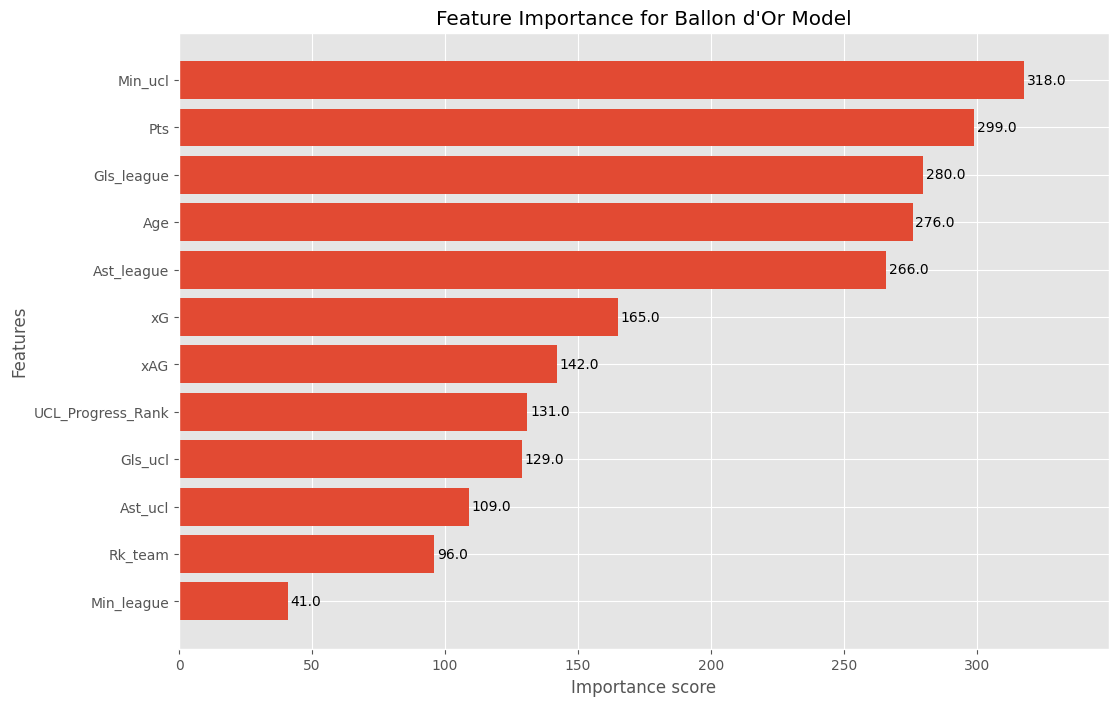

In [47]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot the feature importances to see what the model values most
plt.style.use('ggplot') # Makes the plot look nicer
fig, ax = plt.subplots(figsize=(12, 8))

xgb.plot_importance(model, max_num_features=15, height=0.8, ax=ax, title="Feature Importance for Ballon d'Or Model")
plt.show()

In [16]:
# Run this cell to see all the actual column names
print(ucl_teams_df.columns.tolist())

['Rk_player', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'MP_player', 'Starts', 'Min_league', '90s', 'Gls_league_x', 'Ast_league_x', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls_per_90', 'Ast_per_90', 'G+A_per_90', 'G-PK_per_90', 'G+A-PK_per_90', 'Season', 'League', 'xG_x', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'xG_per_90', 'xAG_per_90', 'xG+xAG_per_90', 'npxG_per_90', 'npxG+xAG_per_90', 'Rk_team', 'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'Top Team Scorer', 'Goalkeeper', 'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'UCL_progress', 'Top_Candidate', 'UCL_Progress_Rank', 'Contender_Score', 'UCL_Winner', 'Gls_league_y', 'Ast_league_y', 'xG_y']


In [48]:
# --- Clean merged DataFrame column names ---
if all(col in ucl_teams_df.columns for col in ['Gls_league_y', 'Ast_league_y', 'xG_y']):
    # Rename the aggregated stats back to clean names
    ucl_teams_df = ucl_teams_df.rename(columns={
        'Gls_league_y': 'Gls_league',
        'Ast_league_y': 'Ast_league',
        'xG_y': 'xG'
    })
    
    # Drop duplicates from the original (pre-merge) columns if present
    ucl_teams_df = ucl_teams_df.drop(columns=['Gls_league_x', 'Ast_league_x', 'xG_x'], errors='ignore')

# --- Verify that the columns exist now ---
print("✅ Columns after cleanup:\n", [c for c in ucl_teams_df.columns if c in ['Gls_league', 'Ast_league', 'xG']])

# --- Check missing values ---
missing_stats = ucl_teams_df[['Gls_league', 'Ast_league', 'xG']].isna().sum()
print("\n🧠 Missing values after merge:\n", missing_stats)

# --- Define features you want to use ---
team_features_to_use = ['GF', 'GA', 'GD', 'Pts', 'Pts/MP']  # example team stats
gls_col, ast_col, xg_col = 'Gls_league', 'Ast_league', 'xG'
final_features = team_features_to_use + [gls_col, ast_col, xg_col]

# --- Prepare training data ---
X_ucl = ucl_teams_df[final_features].fillna(0)
y_ucl = ucl_teams_df['UCL_Winner']

print("\n✅ Final feature columns used for model training:\n", final_features)
print("🧩 X_ucl shape:", X_ucl.shape)
print("🏆 y_ucl value counts:\n", y_ucl.value_counts())


✅ Columns after cleanup:
 ['Gls_league', 'Ast_league', 'xG']

🧠 Missing values after merge:
 Gls_league    0
Ast_league    0
xG            0
dtype: int64

✅ Final feature columns used for model training:
 ['GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'Gls_league', 'Ast_league', 'xG']
🧩 X_ucl shape: (7375, 8)
🏆 y_ucl value counts:
 UCL_Winner
0    7063
1     312
Name: count, dtype: int64


In [49]:
import xgboost as xgb
from sklearn.metrics import classification_report

# --- Split the data (if you haven't already in the same cell) ---
from sklearn.model_selection import train_test_split
X_train_ucl, X_test_ucl, y_train_ucl, y_test_ucl = train_test_split(X_ucl, y_ucl, test_size=0.2, random_state=42, stratify=y_ucl)

# --- Train the UCL Winner Model ---
# We calculate 'scale_pos_weight' to handle the imbalanced data
scale_pos_weight_ucl = (y_train_ucl == 0).sum() / (y_train_ucl == 1).sum()

# Initialize and train the classifier
ucl_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=scale_pos_weight_ucl, 
    random_state=42, 
    eval_metric='logloss'
)
ucl_model.fit(X_train_ucl, y_train_ucl)

print("✅ UCL Winner prediction model trained successfully!")

# --- Evaluate the Model's Performance ---
ucl_predictions = ucl_model.predict(X_test_ucl)
ucl_report = classification_report(y_test_ucl, ucl_predictions, target_names=['Not a Winner (0)', 'UCL Winner (1)'])

print("\n--- UCL Winner Model Evaluation Report ---")
print(ucl_report)

✅ UCL Winner prediction model trained successfully!

--- UCL Winner Model Evaluation Report ---
                  precision    recall  f1-score   support

Not a Winner (0)       1.00      1.00      1.00      1413
  UCL Winner (1)       1.00      1.00      1.00        62

        accuracy                           1.00      1475
       macro avg       1.00      1.00      1.00      1475
    weighted avg       1.00      1.00      1.00      1475



In [62]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os

def make_live_predictions():
    """
    Loads 2026 season data, robustly cleans and converts all data types,
    and uses pre-trained models to predict the Ballon d'Or and UCL winners.
    """
    print("--- Starting Live Prediction Process for 2025-2026 Season ---")
    data_path = '../data/'

    try:
        # 1. Load Your 2026 Season Data Files
        df_league_standings = pd.read_csv(os.path.join(data_path, 'combined_league_standings_2026.csv'))
        df_league_players = pd.read_csv(os.path.join(data_path, 'combined_player_stats_2026.csv'))
        df_ucl_players = pd.read_csv(os.path.join(data_path, 'ucl_player_stats_2026.csv'))
        df_ucl_progress = pd.read_csv(os.path.join(data_path, 'ucl_team_progress_2026.csv'))
        print("\n✅ All 2025-2026 data files loaded successfully.")

    except FileNotFoundError as e:
        print(f"\n--- ERROR --- \nCould not find a required file. Missing file: {e.filename}")
        return

    # --- 2. Merge the 2026 Data ---
    print("\nMerging live data...")
    all_dfs = [df_league_standings, df_league_players, df_ucl_players, df_ucl_progress]
    current_season = '2025-2026'
    for df in all_dfs:
        df['Season'] = current_season
        df.columns = df.columns.str.strip()
        if 'Player' in df.columns: df['Player'] = df['Player'].str.strip()
        if 'Squad' in df.columns: df['Squad'] = df['Squad'].str.strip()
    
    master_df_2026 = pd.merge(df_league_players, df_league_standings, on=['Squad', 'Season'], how='left', suffixes=('_player', '_team'))
    ucl_stats_to_add = df_ucl_players[['Player', 'Squad', 'Gls', 'Ast', 'Min', 'Season']]
    master_df_2026 = pd.merge(master_df_2026, ucl_stats_to_add, on=['Player', 'Squad', 'Season'], how='left', suffixes=('_league', '_ucl'))
    master_df_2026 = pd.merge(master_df_2026, df_ucl_progress, on=['Squad', 'Season'], how='left')
    
    # --- Cleanup (with corrected syntax to remove FutureWarnings) ---
    ucl_cols = ['Gls_ucl', 'Ast_ucl', 'Min_ucl']
    for col in ucl_cols:
        if col in master_df_2026.columns:
            master_df_2026[col] = master_df_2026[col].fillna(0)
    
    master_df_2026['UCL_progress'] = master_df_2026['UCL_progress'].fillna('Did Not Qualify')
    master_df_2026 = master_df_2026.loc[:,~master_df_2026.columns.duplicated()]
    print("2026 master dataset created successfully.")

    # ==============================================================================
    # --- 3. Predict the 2026 Ballon d'Or Winner ---
    # ==============================================================================
    print("\n\n--- Predicting 2026 Ballon d'Or Candidates ---")

    # A) Rename columns to EXACTLY match the model's training data
    rename_dict = {
        'xG_player': 'xG', 'xAG_player': 'xAG',
        'League_Rk': 'Rk_team', 'League_Pts': 'Pts'
    }
    master_df_2026.rename(columns=rename_dict, inplace=True)
    print("\nColumn names have been standardized to match the trained model.")

    # B) Prepare the feature set using the model's expected names
    features_to_use_bdo = [
        'Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG', 'xAG',
        'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts', 'UCL_Progress_Rank'
    ]
    
    # C) --- THIS IS THE DEFINITIVE FIX ---
    # Ensure all feature columns exist and are converted to a numeric type.
    print("Converting all feature columns to numeric types for prediction...")
    for col in features_to_use_bdo:
        if col not in master_df_2026.columns:
            master_df_2026[col] = 0 # Add missing column and fill with 0
        # Force the column to be numeric, turning any errors into 'NaN' (missing)
        master_df_2026[col] = pd.to_numeric(master_df_2026[col], errors='coerce')
            
    # D) Prepare the final feature matrix for the model
    progress_mapping = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'League Phase': 6, 'Did Not Qualify': 7}
    master_df_2026['UCL_Progress_Rank'] = master_df_2026['UCL_progress'].str.strip().map(progress_mapping).fillna(7)
    
    X_live_bdo = master_df_2026[features_to_use_bdo].fillna(0)
    
    # E) Use the pre-trained 'model' to predict probabilities
    bdo_scores = model.predict_proba(X_live_bdo)[:, 1]
    master_df_2026['Contender_Score'] = bdo_scores
    
    bdo_predictions = master_df_2026.sort_values(by='Contender_Score', ascending=False)
    print("\n🏆 Top 20 Ballon d'Or Predictions (Live):")
    display(bdo_predictions[['Player', 'Squad', 'Gls_league', 'Gls_ucl', 'Contender_Score']].head(20))

# --- Main Execution ---
if 'model' in locals():
    make_live_predictions()
else:
    print("\n--- ERROR --- Please ensure your Ballon d'Or model ('model') is trained and available in memory.")

--- Starting Live Prediction Process for 2025-2026 Season ---

✅ All 2025-2026 data files loaded successfully.

Merging live data...
2026 master dataset created successfully.


--- Predicting 2026 Ballon d'Or Candidates ---

Column names have been standardized to match the trained model.
Converting all feature columns to numeric types for prediction...

🏆 Top 20 Ballon d'Or Predictions (Live):


,Player,Squad,Gls_league,Gls_ucl,Contender_Score
994,Ritsu Doan,Eint Frankfurt,2,0.0,0.012665
903,Lamine Yamal,Barcelona,2,0.0,0.011547
193,João Pedro,Chelsea,2,0.0,0.010418
1375,Valentín Castellanos,Lazio,2,0.0,0.005649
1270,Can Uzun,Eint Frankfurt,5,0.0,0.003408
1256,Jan Thielmann,Köln,2,0.0,0.000969
126,Cody Gakpo,Liverpool,2,0.0,0.000829
720,Georges Mikautadze,Villarreal,2,0.0,0.000689
1415,Federico Dimarco,Inter,2,0.0,0.000686
1899,Matias Fernandez-Pardo,Lille,2,0.0,0.000413
